(mmm_causal_ladder)=
# MMMs and Pearl's ladder of causal inference

In this notebook, we will explore [Judea Pearl's](https://en.wikipedia.org/wiki/Judea_Pearl) causal ladder and how it can be applied to solve business problems with Media Mix Models (MMMs). We will assume familiarity with the basics of MMMs in order to focus on causal inference.

## What is Pearl's causal ladder?

Pearl's causal ladder outlines 3 successively more sophisticated levels of causal reasoning:

1. **Prediction / Forecasting / Association:** With the first step on the ladder, we could use a model to predict future sales based on past data. This does not involve causal reasoning, just prediction.

2. **Intervention:** The second step on the ladder involves using a model to predict the future effect of an intervention. It is similar to step 1 in that it involves prediction/forecasting, but it is different in that we consder a potential intervention that will have effects in the future.

3. **Counterfactuals:** The third and final step on the ladder could use a to estimate how the world _would_ have been different if we had taken a different action in the past. This is clearly different from the first two steps in that it is retrospective. It is also the most sophisticated level of causal reasoning - it involves learning about the world from historical data, but then imagining how the world _could_ have been different in a counterfactual scenario.

![Causal Ladder](../../_static/causal_ladder.png)

## How does this help us solve business problems?

Now we've recapped the causal ladder, let's consider how it can help us solve business problems, specifically with MMMs. Let's look at a few example use cases and see what level of the causal ladder they correspond to:

* **Predicting future sales:** A very common use-case of MMM's is to make forecasts of our outcome variable (e.g. sales). This can be particularly useful ingredient in demand forecasting for example. Once we've trained an MMM on historical data we can use the MMM to predict future sales (out of sample prediction) based on past sales, marketing spend, and other predictor variables. This would correspond to step 1 on the causal ladder - we are forecasting into the future but not considering any changes to our marketing strategy.

* **Optimizing existing marketing spend:** A more sophisticated use-case of MMM's is to use the model to predict the effect of different marketing strategies. For example, we could use it to predict the effect of various different changes to media spend. We could then predict the expected sales under these scenarios and pick a scenario which maximises sales or profit, for example. This corresponds to step 2 on the causal ladder - intervention. This is a more sophisticated level of causal reasoning, as it involves prediction, but in the presence of an altered marketing strategy (an intervention).

* **Planning an increase in marketing spend:** Let's say our business wants to gain more market share and has decided to increase marketing spend by 20% over the next quarter. You are tasked with proposing a number of different future media spend strategies that you think will cause the largest increase in sales. This corresponds to step 2 on the causal ladder - intervention. We are predicting the effect of an intervention (increasing media spend) on sales.

* **Evaluating the impact of a previous increase in marketing spend:** Let's say our business increased TV spend by 20% over the last quarter and we want to know what impact this had on sales. We can answer this question by comparing what _actually_ happened, to what we think _would have happened_ under some alternative imagined counterfactual scenario such as not increasing TV spend by 20%. Importantly, this counterfactual reasoning is _retrospective_, but it uses the knowledge we have learnt from all observations so far. This corresponds to step 3 on the causal ladder - counterfactual inference. We are learning from historical data, but then imagining how the world _could_ have been different in a counterfactual scenario. So this involves retrospective causal reasoning.

## Setup

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import xarray as xr

from pymc_marketing.mmm import MMM, GeometricAdstock, LogisticSaturation
from pymc_marketing.mmm.transformers import geometric_adstock, logistic_saturation

In [2]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

In [3]:
plt.rcParams["figure.figsize"] = [12, 7]
seed: int = sum(map(ord, "mmm"))
rng: np.random.Generator = np.random.default_rng(seed=seed)

## Level 1 - Prediction

We can use MMM's to predict future sales based on what we have learnt from historical data. This is a common use-case of MMM's and corresponds to step 1 on the causal ladder.

**_TODO: I have not yet decided if I'll include an example here. Regardless, I'll reference other notebooks._**

:::{seealso}
For the sake of brevity, and to avoid duplication, we will not walk through the process here. It is covered in detail in the {ref}`mmm_example` (see section on out of sample prediction) and also the notebook on {ref}`mmm_time_slice_cross_validation`.
:::

## Level 2 - Intervention

**_TODO: I have not yet decided if I'll include an example here. Regardless, I'll reference the budget allocation notebook._**

:::{seealso}
For much more information on using Level 2 of the causal ladder, see the dedicated notebook on {ref}`mmm_budget_allocation_example`.
:::

## Level 3 - Counterfactual inference

To signpost what we are going to do, the broad steps are as follows:

* Generate simulated data from both an _actual_ scenario where we conducted a marketing campaign, and a _counterfactual_ scenario where we did not conduct the marketing campaign. To be clear, we can never directly observe the counterfactual scenario (whatever it may be) because it is a hypothetical scenario which did not actuall happen. However, when we invove God Mode, we can simulate both actual and counterfactual scenarios.
* Train an MMM on _all_ the actual data - this will include data from before the marketing intervention, during the campaign, and also after the campaign.
* We can then use the MMM to predict what would have happened in the counterfactual scenario. This is the key step - we are using the MMM to predict what would have happened if we had not conducted the marketing campaign.
* We can then compare the actual and counterfactual scenarios to estimate the effect of the marketing campaign.

:::{admonition} Parameter estimation
:class: note

The logic of running through these steps on simulated actual and counterfactual data is that we can compare the MMM's ability to estimate the causal impact of the marketing campaign to the true causal impact that we know because we simulated the data. If we do ok here, we can be more confident that the MMM will be able to estimate the causal impact of the marketing campaign on real data where only the actual data is available.
:::

### Generating synthetic 'actual' and 'counterfactual' data

Taken from https://www.pymc-marketing.io/en/stable/notebooks/mmm/mmm_example.html

In [4]:
def forward_pass(df_in):
    """Run predictor variables through the forward pass of the model.

    Given a dataframe with spend data columns `x1` and `x2`, run this through the
    transformations and return the response variable `y`.
    """
    df = df_in.copy()

    n = df.shape[0]

    # apply geometric adstock transformation
    alpha1: float = 0.4
    alpha2: float = 0.2

    df["x1_adstock"] = (
        geometric_adstock(x=df["x1"].to_numpy(), alpha=alpha1, l_max=8, normalize=True)
        .eval()
        .flatten()
    )

    df["x2_adstock"] = (
        geometric_adstock(x=df["x2"].to_numpy(), alpha=alpha2, l_max=8, normalize=True)
        .eval()
        .flatten()
    )

    # apply saturation transformation
    lam1: float = 4.0
    lam2: float = 3.0

    df["x1_adstock_saturated"] = logistic_saturation(
        x=df["x1_adstock"].to_numpy(), lam=lam1
    ).eval()

    df["x2_adstock_saturated"] = logistic_saturation(
        x=df["x2_adstock"].to_numpy(), lam=lam2
    ).eval()

    # trend and seasonality
    df["trend"] = (np.linspace(start=0.0, stop=50, num=n) + 10) ** (1 / 4) - 1

    df["cs"] = -np.sin(2 * 2 * np.pi * df["dayofyear"] / 365.5)
    df["cc"] = np.cos(1 * 2 * np.pi * df["dayofyear"] / 365.5)
    df["seasonality"] = 0.5 * (df["cs"] + df["cc"])

    # random events
    df["event_1"] = (df["date_week"] == "2019-05-13").astype(float)
    df["event_2"] = (df["date_week"] == "2020-09-14").astype(float)

    df["intercept"] = 2.0
    if "epsilon" not in df.columns:
        df["epsilon"] = rng.normal(loc=0.0, scale=0.25, size=n)

    amplitude = 1
    beta_1 = 3.0
    beta_2 = 2.0

    # forward pass
    df["y"] = amplitude * (
        df["intercept"]
        + df["trend"]
        + df["seasonality"]
        + 1.5 * df["event_1"]
        + 2.5 * df["event_2"]
        + beta_1 * df["x1_adstock_saturated"]
        + beta_2 * df["x2_adstock_saturated"]
        + df["epsilon"]
    )
    return df


def generate_counterfactual_dataset(rng):
    """Generate a synthetic dataset.

    For the counterfactual scenario of no advertising campaign.
    """
    # date range
    min_date = pd.to_datetime("2018-04-01")
    max_date = pd.to_datetime("2021-09-01")

    df = pd.DataFrame(
        data={"date_week": pd.date_range(start=min_date, end=max_date, freq="W-MON")}
    ).assign(
        year=lambda x: x["date_week"].dt.year,
        month=lambda x: x["date_week"].dt.month,
        dayofyear=lambda x: x["date_week"].dt.dayofyear,
    )

    n = df.shape[0]
    print(f"Number of observations: {n}")

    # media data
    x1 = rng.uniform(low=0.0, high=1.0, size=n)
    df["x1"] = np.where(x1 > 0.9, x1, x1 / 2)

    x2 = rng.uniform(low=0.0, high=1.0, size=n)
    df["x2"] = np.where(x2 > 0.8, x2, 0)

    df = forward_pass(df)
    return df

In [5]:
df_counterfactual = generate_counterfactual_dataset(rng)
df_counterfactual.head()

Number of observations: 179


,date_week,year,month,dayofyear,x1,x2,x1_adstock,x2_adstock,x1_adstock_saturated,x2_adstock_saturated,trend,cs,cc,seasonality,event_1,event_2,intercept,epsilon,y
0,2018-04-02,2018,4,92,0.318580,0.0,0.191273,0.0,0.364917,0.0,0.778279,0.021487,-0.010744,0.005371,0.0,0.0,2.0,0.106260,3.984662
1,2018-04-09,2018,4,99,0.112388,0.0,0.143987,0.0,0.280268,0.0,0.790638,0.259165,-0.130704,0.064231,0.0,0.0,2.0,0.067198,3.762872
2,2018-04-16,2018,4,106,0.292400,0.0,0.233150,0.0,0.435205,0.0,0.802746,0.481904,-0.248773,0.116566,0.0,0.0,2.0,0.242042,4.466967
3,2018-04-23,2018,4,113,0.071399,0.0,0.136127,0.0,0.265721,0.0,0.814614,0.676865,-0.363245,0.156810,0.0,0.0,2.0,0.095631,3.864219
4,2018-04-30,2018,4,120,0.386745,0.0,0.286650,0.0,0.517779,0.0,0.826254,0.832810,-0.472462,0.180174,0.0,0.0,2.0,-0.118140,4.441625


Now generate a dataframe for the _actual_ situation where an experimental intervention took place. This will be a period of time where media spend was increased.

In [6]:
def generate_actual_dataset(
    df_counterfactual: pd.DataFrame, intervention_date
) -> pd.DataFrame:
    """Generate the 'actual' dataset.

    Based on the counterfactual dataset, apply the intervention on the specified date
    and return the actual dataset.
    """
    df = df_counterfactual[["date_week", "dayofyear", "x1", "x2", "epsilon"]].copy()
    # increase x1 by 40% in for date_week from 2021-01-01 onwards
    df.loc[df["date_week"] > intervention_date, "x1"] *= 1.40
    df = forward_pass(df)
    return df


intervention_date = "2021-01-01"
df_actual = generate_actual_dataset(df_counterfactual, intervention_date)
df_actual.head()

,date_week,dayofyear,x1,x2,epsilon,x1_adstock,x2_adstock,x1_adstock_saturated,x2_adstock_saturated,trend,cs,cc,seasonality,event_1,event_2,intercept,y
0,2018-04-02,92,0.318580,0.0,0.106260,0.191273,0.0,0.364917,0.0,0.778279,0.021487,-0.010744,0.005371,0.0,0.0,2.0,3.984662
1,2018-04-09,99,0.112388,0.0,0.067198,0.143987,0.0,0.280268,0.0,0.790638,0.259165,-0.130704,0.064231,0.0,0.0,2.0,3.762872
2,2018-04-16,106,0.292400,0.0,0.242042,0.233150,0.0,0.435205,0.0,0.802746,0.481904,-0.248773,0.116566,0.0,0.0,2.0,4.466967
3,2018-04-23,113,0.071399,0.0,0.095631,0.136127,0.0,0.265721,0.0,0.814614,0.676865,-0.363245,0.156810,0.0,0.0,2.0,3.864219
4,2018-04-30,120,0.386745,0.0,-0.118140,0.286650,0.0,0.517779,0.0,0.826254,0.832810,-0.472462,0.180174,0.0,0.0,2.0,4.441625


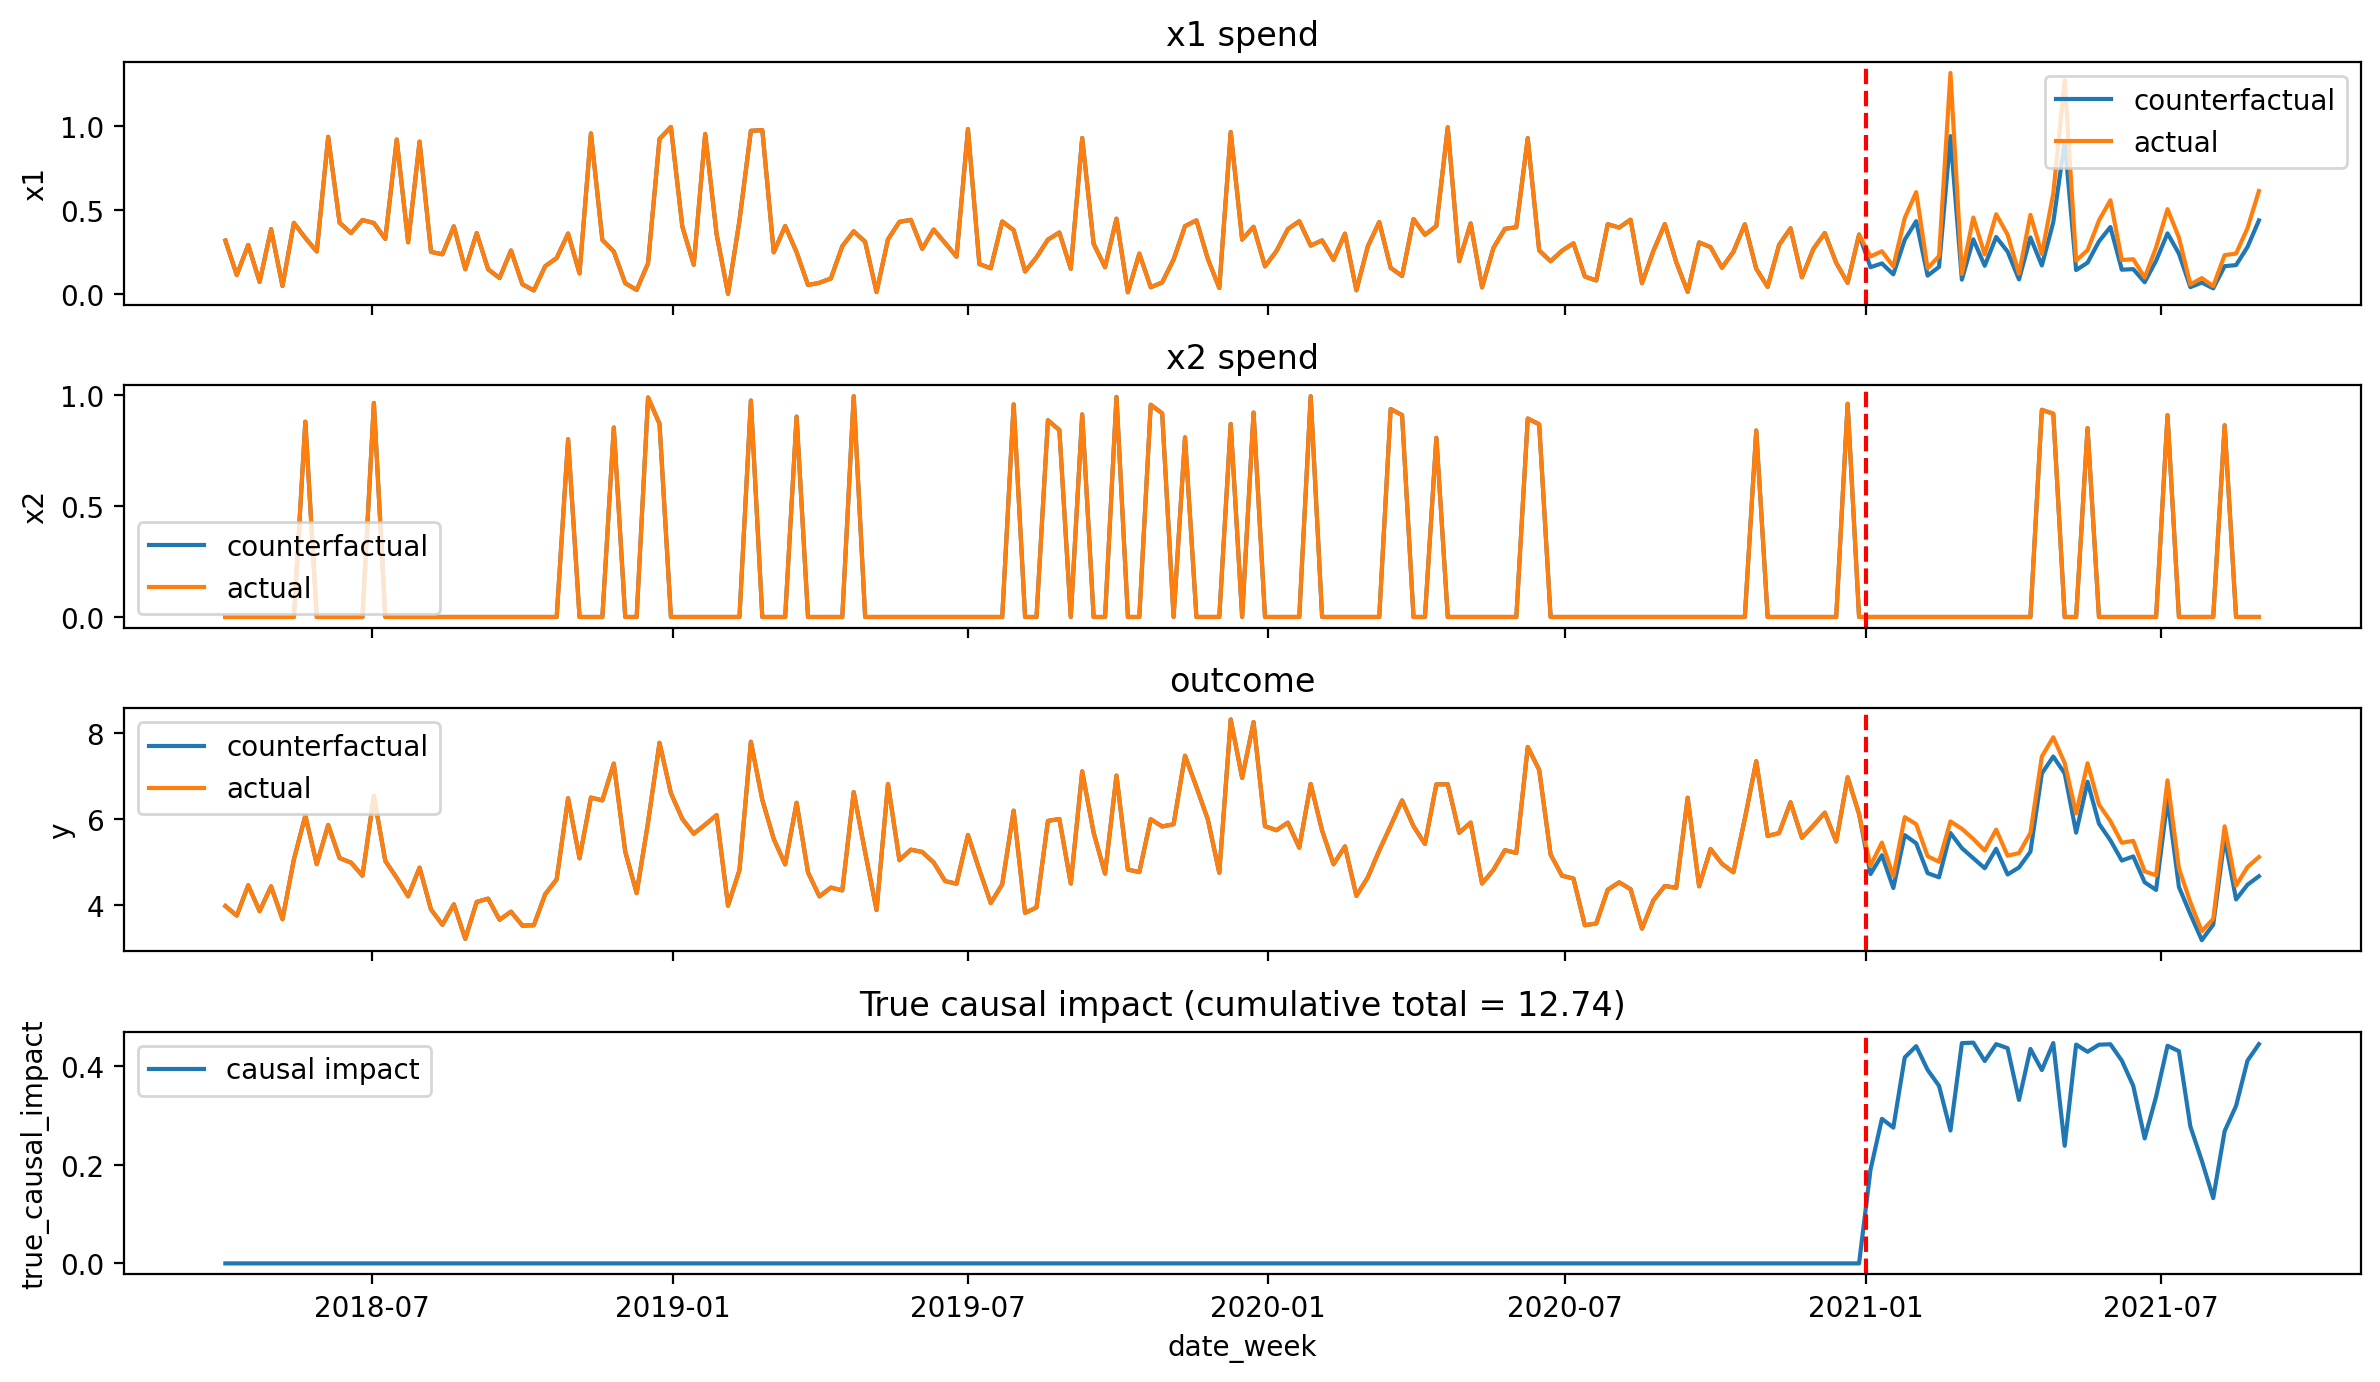

In [7]:
fig, ax = plt.subplots(4, 1, sharex=True)

sns.lineplot(
    x="date_week", y="x1", data=df_counterfactual, label="counterfactual", ax=ax[0]
)
sns.lineplot(x="date_week", y="x1", data=df_actual, label="actual", ax=ax[0])
ax[0].set(title="x1 spend")

sns.lineplot(
    x="date_week", y="x2", data=df_counterfactual, label="counterfactual", ax=ax[1]
)
sns.lineplot(x="date_week", y="x2", data=df_actual, label="actual", ax=ax[1])
ax[1].set(title="x2 spend")

sns.lineplot(
    x="date_week", y="y", data=df_counterfactual, label="counterfactual", ax=ax[2]
)
sns.lineplot(x="date_week", y="y", data=df_actual, label="actual", ax=ax[2])
ax[2].set(title="outcome")

# calculate true causal impact
new_df = pd.DataFrame()
new_df["date_week"] = df_actual["date_week"]
new_df["true_causal_impact"] = df_actual["y"] - df_counterfactual["y"]

sns.lineplot(
    x="date_week", y="true_causal_impact", data=new_df, label="causal impact", ax=ax[3]
)
cumulative_impact = new_df["true_causal_impact"].sum()
ax[3].set(title=f"True causal impact (cumulative total = {cumulative_impact:.2f})")

# plot intervention point
for i in [0, 1, 2, 3]:
    ax[i].axvline(
        x=pd.to_datetime(intervention_date),
        color="red",
        linestyle="--",
        label="intervention date",
    )

plt.tight_layout();

Because we are simulating this world, we know the true causal impact.

### Train an MMM on the actual data

In the real world, we only have access to the df_actual data. Our goal will be to infer the causal impact of the intervention.

* Train MMM on data available to us in df_actual. This will include the whole time series available to us.
* Evaluate the model's predictions in the counterfactual world where the intervention did not take place.
  * This will be done by using `pm.set_data` so that x1 is equal to the spend in the counterfactual world where no intervention took place. So this approach does assume that we know (or can estimate) the counterfactual spend.


In [8]:
data = df_actual.copy()
# feature engineering
n = data.shape[0]
data["t"] = range(n)
# prepare data for model
X = data.drop("y", axis=1)
y = data["y"]

In [9]:
mmm = MMM(
    date_column="date_week",
    adstock=GeometricAdstock(l_max=8),
    saturation=LogisticSaturation(),
    channel_columns=["x1", "x2"],
    control_columns=[
        "event_1",
        "event_2",
        "t",
    ],
    yearly_seasonality=2,
)

In [10]:
mmm.sample_prior_predictive(X, y, samples=2_000)

mmm.fit(X=X, y=y, target_accept=0.85, chains=4, random_seed=rng)

mmm.sample_posterior_predictive(X, extend_idata=True, combined=True);

Sampling: [adstock_alpha, gamma_control, gamma_fourier, intercept, saturation_beta, saturation_lam, y, y_sigma]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, adstock_alpha, saturation_lam, saturation_beta, gamma_control, gamma_fourier, y_sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 20 seconds.
Sampling: [y]


Output()

The plot below represents the MMM fit to the actual data

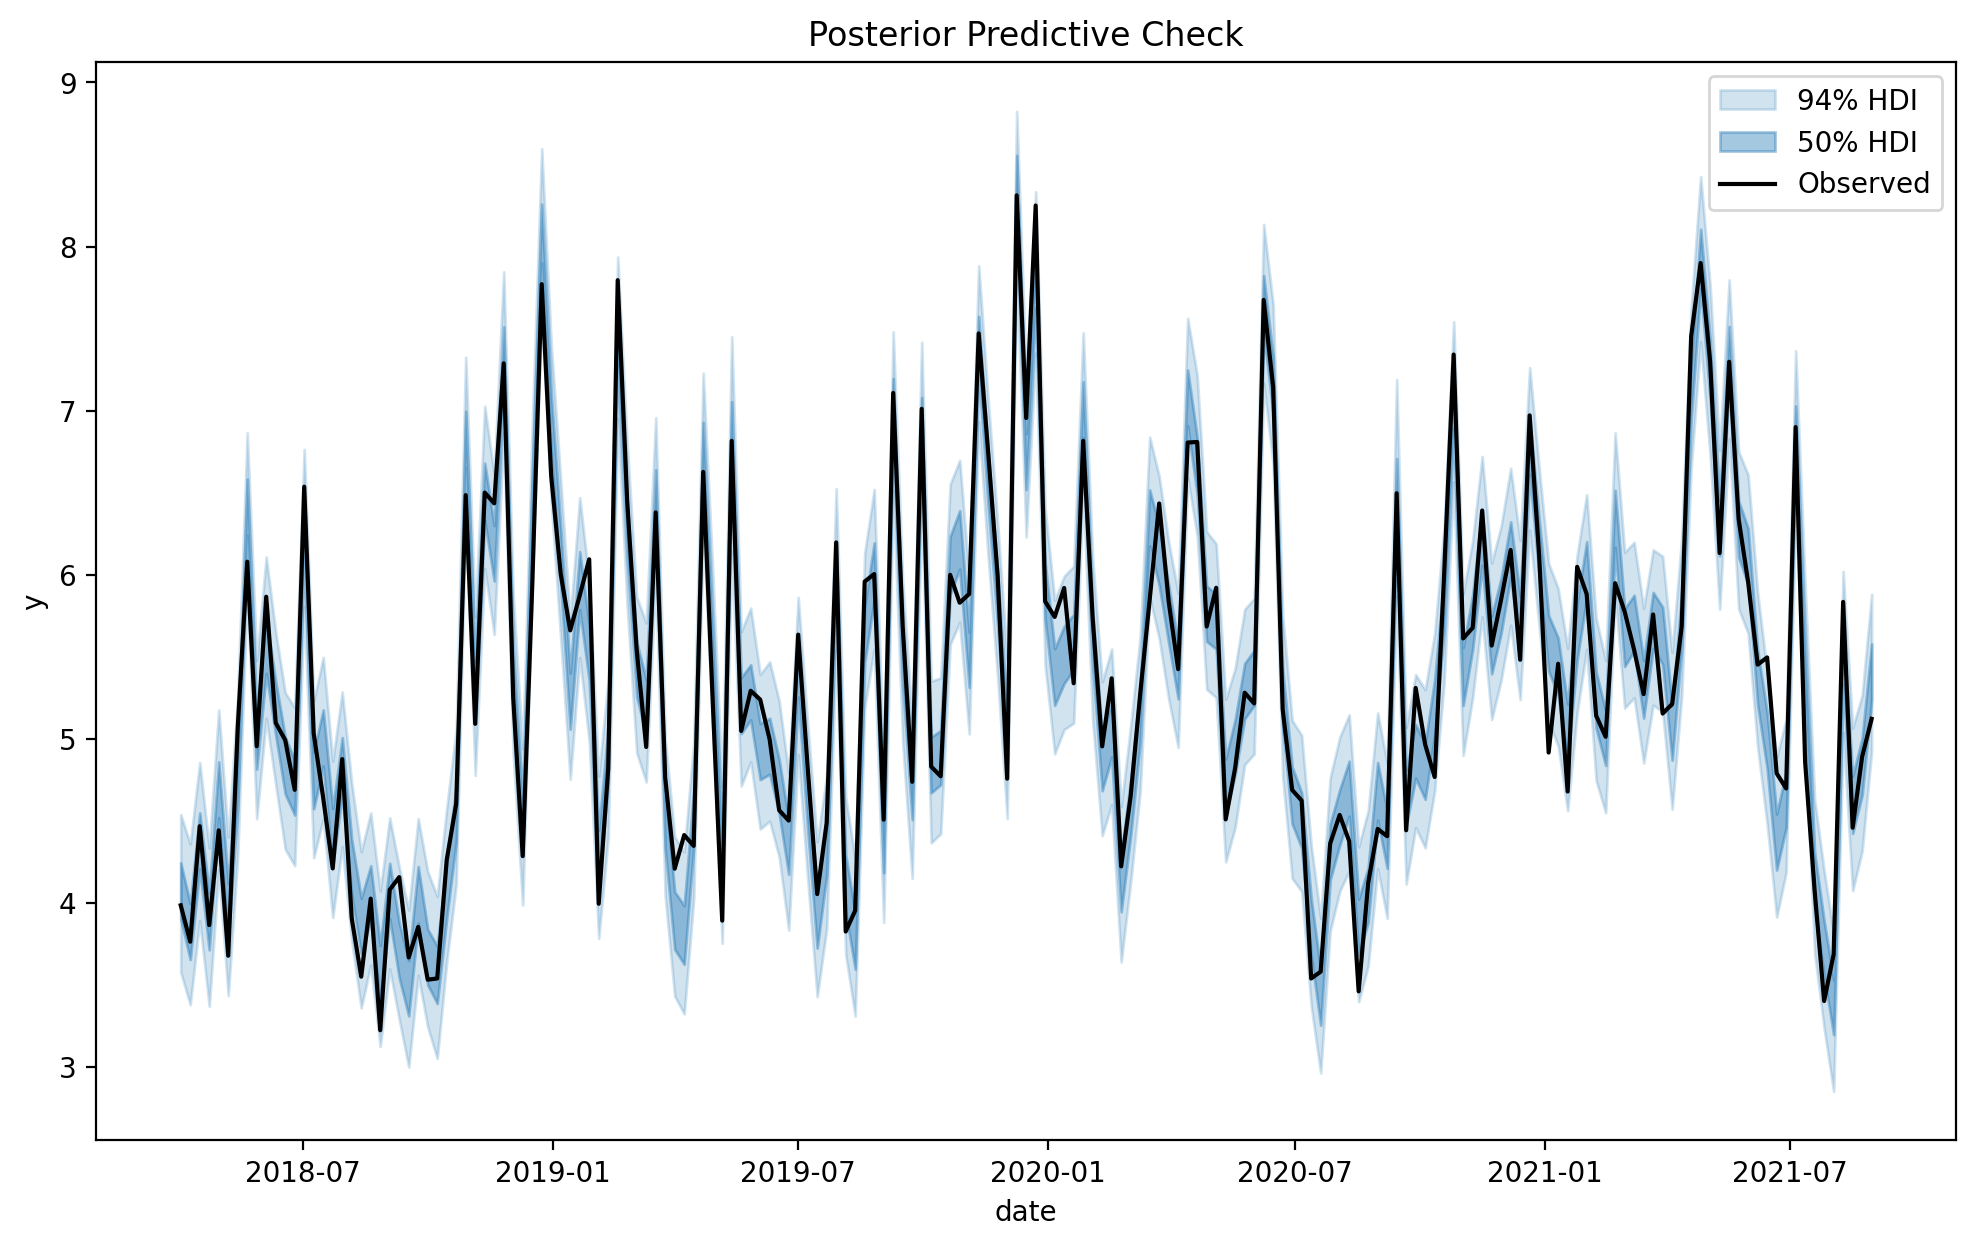

In [11]:
mmm.plot_posterior_predictive(original_scale=True);

### Counterfactual inference

Now we want to evaluate what the model thinks would have happened in the counterfactual scenario that the intervention did not take place. For this, we will use the counterfactual spend in `df_counterfactual.x1`.

In [12]:
X_counterfactual = df_counterfactual[["date_week", "x1", "x2", "event_1", "event_2"]]

X_counterfactual["t"] = range(n)

X_counterfactual.head()

/var/folders/3d/p29f9frn6d3c3gnfq2bxbd1c0000gn/T/ipykernel_4959/1187989113.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_counterfactual["t"] = range(n)


,date_week,x1,x2,event_1,event_2,t
0,2018-04-02,0.318580,0.0,0.0,0.0,0
1,2018-04-09,0.112388,0.0,0.0,0.0,1
2,2018-04-16,0.292400,0.0,0.0,0.0,2
3,2018-04-23,0.071399,0.0,0.0,0.0,3
4,2018-04-30,0.386745,0.0,0.0,0.0,4


In [13]:
y_counterfactual = mmm.sample_posterior_predictive(
    X_pred=X_counterfactual, extend_idata=False
);

Sampling: [y]


Output()

### Calculate the causal impact

In [14]:
# Calculate causal impact
y_obs = xr.DataArray(df_actual["y"].to_numpy(), dims=["date"])
causal_impact = y_obs - y_counterfactual["y"]

### Plot counterfactual predictions

/var/folders/3d/p29f9frn6d3c3gnfq2bxbd1c0000gn/T/ipykernel_4959/3525664033.py:9: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  X_counterfactual["date_week"].dt.to_pydatetime(),
/var/folders/3d/p29f9frn6d3c3gnfq2bxbd1c0000gn/T/ipykernel_4959/3525664033.py:24: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  X_counterfactual["date_week"].dt.to_pydatetime(),
/var/folders/3d/p29f9frn6d3c3gnfq2bxbd1c0000gn/T/ipykernel_4959/3525664033.py:46: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead o

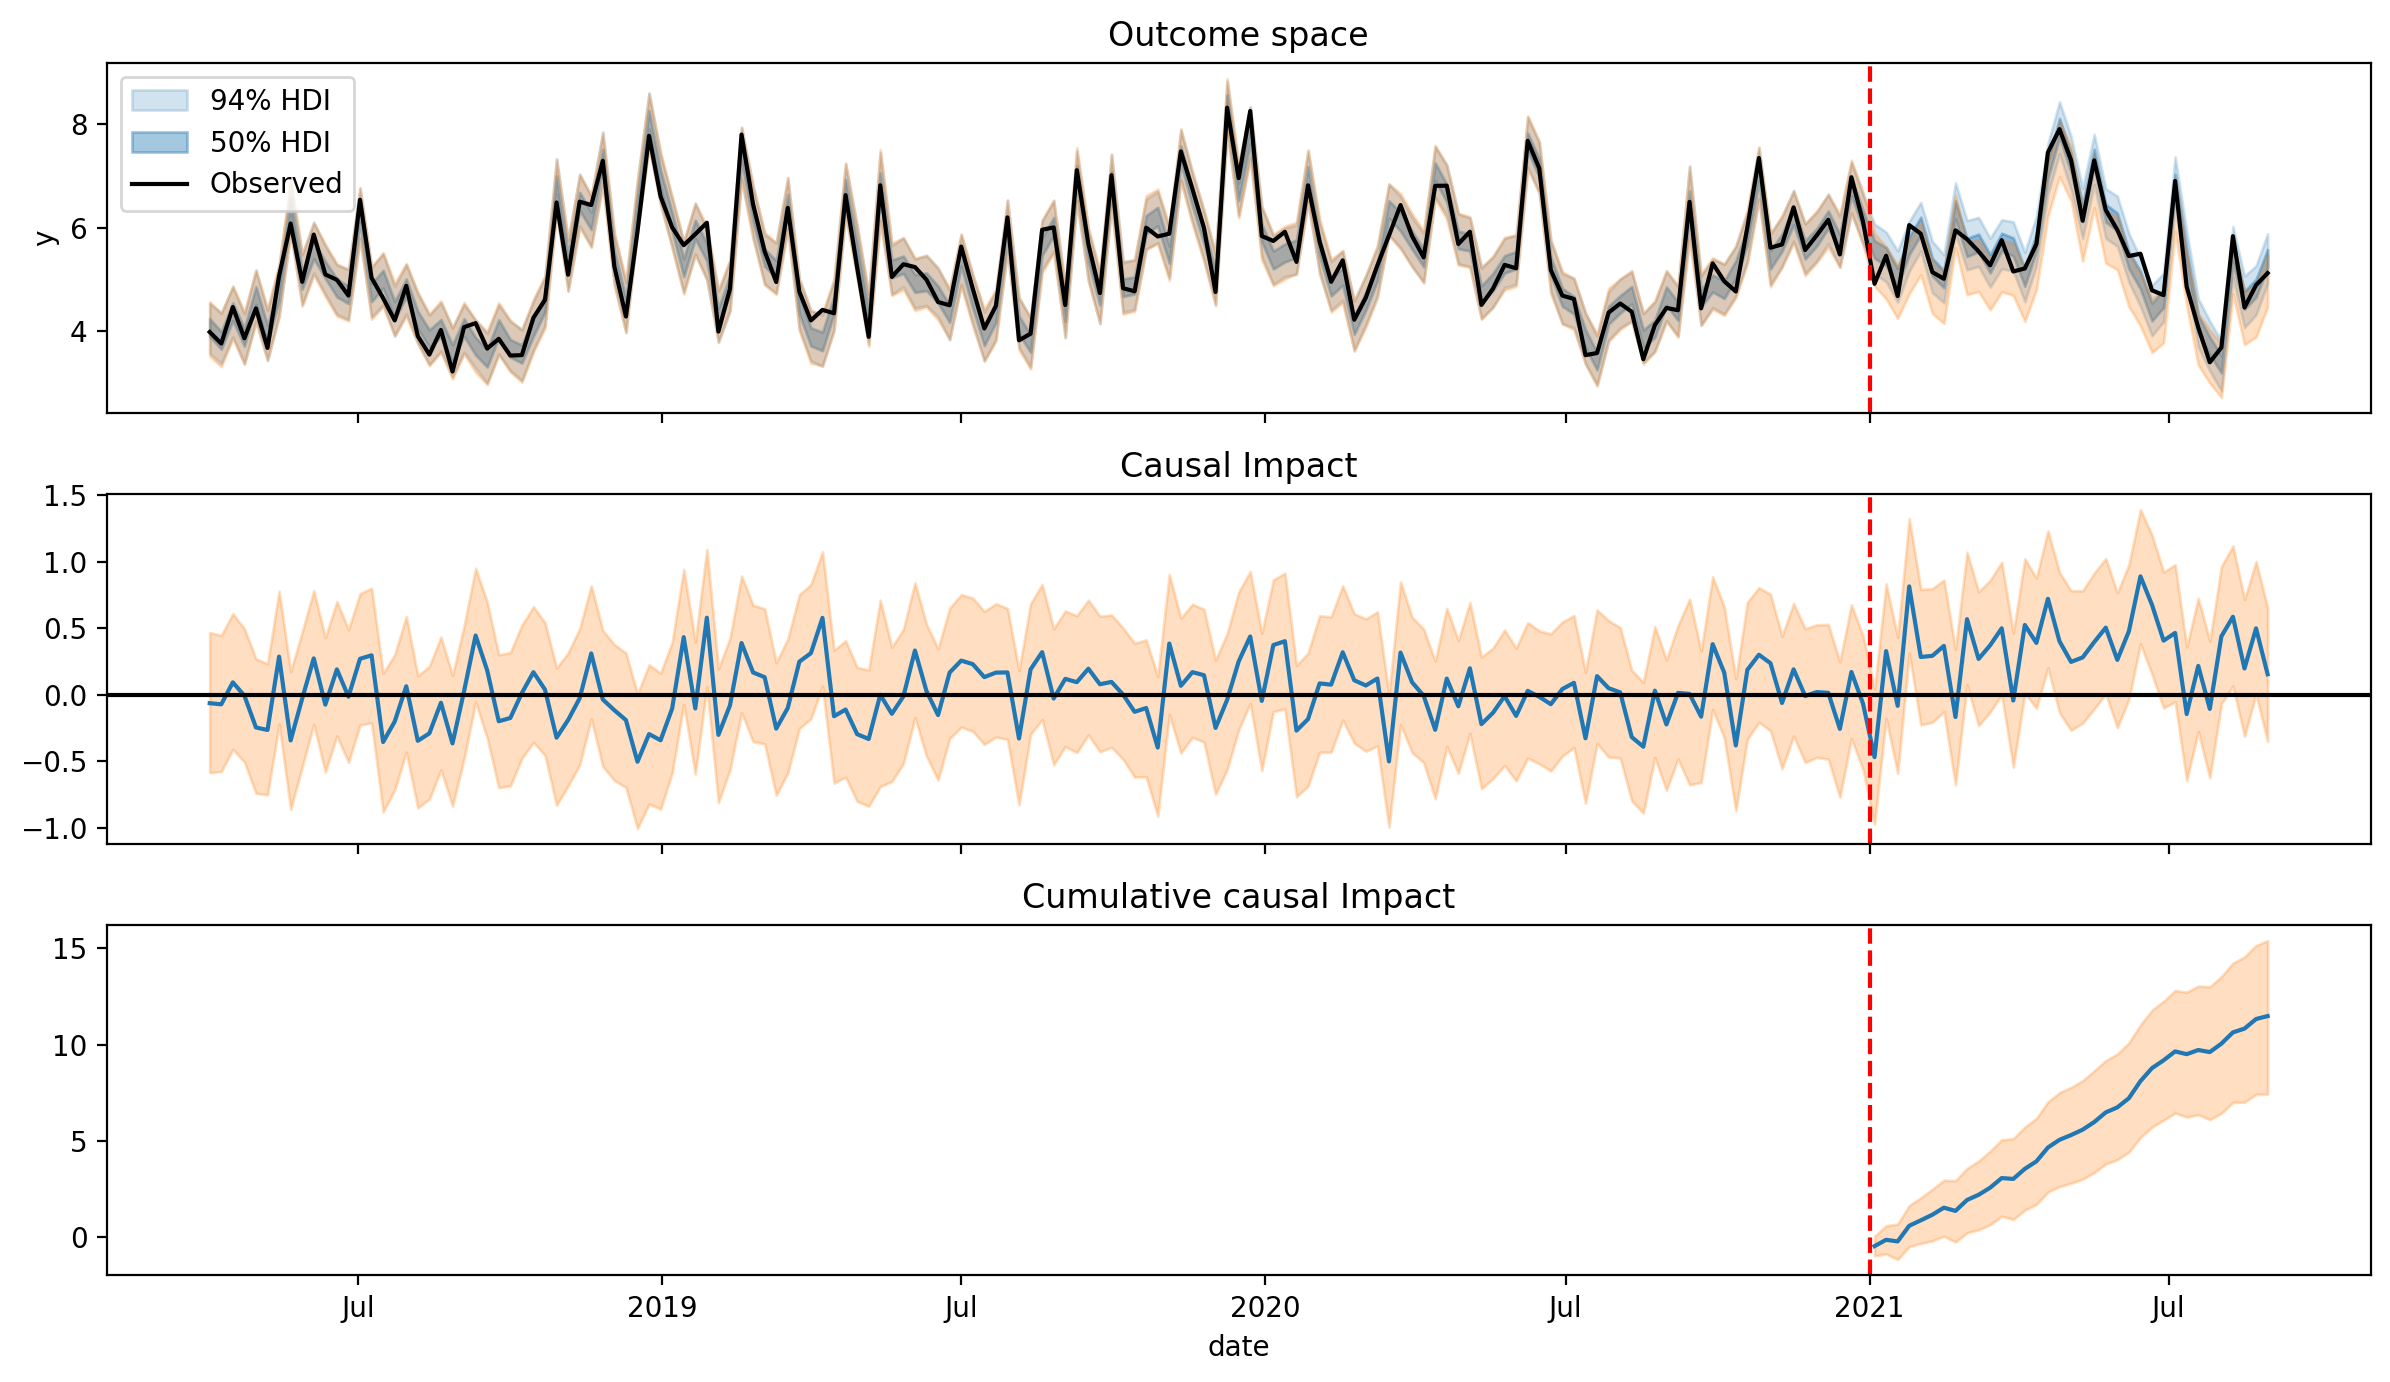

In [15]:
fig, ax = plt.subplots(3, 1, sharex=True)

# TOP PLOT - OUTCOME SPACE -------------------------------------------------------------
mmm.plot_posterior_predictive(original_scale=True, ax=ax[0])

# plot counterfactual
y_counterfactual["y"].quantile([0.025, 0.975], dim=["sample"])
ax[0].fill_between(
    X_counterfactual["date_week"].dt.to_pydatetime(),
    y_counterfactual["y"]
    .quantile([0.025, 0.975], dim=["sample"])
    .sel({"quantile": 0.025}),
    y_counterfactual["y"]
    .quantile([0.025, 0.975], dim=["sample"])
    .sel({"quantile": 0.975}),
    alpha=0.25,
    color="C1",
    # label=f"{label} interval",
)
ax[0].set(title="Outcome space", xlabel="")

# BOTTOM PLOT - COUNTERFACTUAL SPACE ---------------------------------------------------
ax[1].fill_between(
    X_counterfactual["date_week"].dt.to_pydatetime(),
    causal_impact.quantile([0.025, 0.975], dim=["sample"]).sel({"quantile": 0.025}),
    causal_impact.quantile([0.025, 0.975], dim=["sample"]).sel({"quantile": 0.975}),
    alpha=0.25,
    color="C1",
    # label=f"{label} interval",
)
# plot posterior predictive mean
causal_impact.mean(dim="sample").plot(ax=ax[1], label="casual impact mean")
ax[1].axhline(y=0, color="black", label="zero")
ax[1].set(title="Causal Impact", xlabel="")

# BOTTOM PLOT - CUMULATIVE CAUSAL IMPACT ---------------------------------------------------
# select X_counterfactual where date_week is greater than intervention_date
_X_counterfactual = X_counterfactual[X_counterfactual["date_week"] >= intervention_date]
# select counterfactual where date_week is greater than intervention_date
_causal_impact = causal_impact.sel({"date": slice(intervention_date, None)})
cum_causal_impact = _causal_impact.cumsum(dim="date")
ax[2].plot(
    _X_counterfactual["date_week"], cum_causal_impact.mean(dim="sample"), label="mean"
)
ax[2].fill_between(
    _X_counterfactual["date_week"].dt.to_pydatetime(),
    cum_causal_impact.quantile([0.025, 0.975], dim=["sample"]).sel({"quantile": 0.025}),
    cum_causal_impact.quantile([0.025, 0.975], dim=["sample"]).sel({"quantile": 0.975}),
    alpha=0.25,
    color="C1",
    # label=f"{label} interval",
)
ax[2].set(title="Cumulative causal Impact", xlabel="date")

# plot intervention point
for i in [0, 1, 2]:
    ax[i].axvline(
        x=pd.to_datetime(intervention_date),
        color="red",
        linestyle="--",
        label="intervention date",
    )

plt.tight_layout();

## Summary

In [16]:
%load_ext watermark
%watermark -n -u -v -iv -w -p pymc_marketing,pytensor

Last updated: Sat Sep 14 2024

Python implementation: CPython
Python version       : 3.10.14
IPython version      : 8.27.0

pymc_marketing: 0.8.0
pytensor      : 2.22.1

matplotlib: 3.9.2
seaborn   : 0.13.2
pymc      : 5.15.1
numpy     : 1.26.4
xarray    : 2024.9.0
pandas    : 2.2.2

Watermark: 2.4.3

